In [1]:
from tensorflow.keras.layers import Dense,BatchNormalization,LeakyReLU,Conv2DTranspose,Reshape,Conv2D,Dropout,Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

D:\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# Dataset中的buffer
buffer_size = 60000
# 批次大小
batch_size = 256
# 训练周期
epochs = 51
# 100维的随机噪声
noise_dim = 100

In [3]:
# 载入MNNIST数据，只需要训练集的图片就可以
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# reshape为4维数据
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
# 将图片归一化到 [0, 1] 区间内
train_images = train_images/ 255.0

In [4]:
# 定义Dataset，用于生成打乱后的批次数据
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [5]:
# 定义生成器
def generator_model():
    # 顺序模型
    model = tf.keras.Sequential()
    # 传入噪声数据，然后与7*7*256个神经元进行全连接
    # 7*7*256主要是为了后面可以Reshape变成(7, 7, 256)
    model.add(Dense(7*7*256, input_shape=(noise_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    # 变成4维图像数据(-1,7,7,256)
    model.add(Reshape((7, 7, 256)))
    # 转置卷积，图像shape变成(-1,7,7,128)
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    # 转置卷积，图像shape变成(-1,14,14,64)
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    # 转置卷积，图像shape变成(-1,28,28,1)
    # 激活函数使用sigmoid，主要是因为我们把MNIST数据图片归一化为[0,1]之间了，生成的假图片要跟真实图片数据匹配
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'))
    return model

In [6]:
# 定义判别器
def discriminator_model():
    # 顺序模型
    model = tf.keras.Sequential()
    # 传入一张图片数据进行卷积，卷积后图像shape为(1,14,14,64)
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    # 卷积后图像shape为(1,7,7,128)
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Flatten())
    # 最后输出一个值，激活函数为sigmoid函数，用于判断图片的真假
    model.add(Dense(1, activation='sigmoid'))
    return model

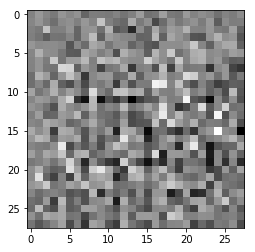

In [7]:
# 创建生成器模型
generator = generator_model()
# 创建判别器模型
discriminator = discriminator_model()
# 生成随机数
noise = tf.random.normal([1, noise_dim])
# 传入生成器生成一张图片
generated_image = generator(noise, training=False)
# 显示出图片，刚开始模型还没有训练，所以生成的图片会得到噪声图片
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [8]:
# 定义2分类交叉熵代价函数
cross_entropy = tf.keras.losses.BinaryCrossentropy()

# 判别器loss，传入对真实图片的判断结果以及对假图片的判断结果
def discriminator_loss(real_output, fake_output):
    # tf.ones_like(real_output)表示对真实图片的判断结果应该全为1
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # tf.zeros_like(fake_output)表示对假图片的判断结果应该全为0
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # 求总loss，再返回
    total_loss = real_loss + fake_loss
    return total_loss

In [9]:
# 生成器loss，传入判别器对假图片的判断结果
def generator_loss(fake_output):
    # 对于生成器来说，生成器希望判别器对假图片的判断结果都是1
    # 所以标签设定为tf.ones_like(fake_output)，全为1
    # 生成器模型在训练过程中会不断优化自身参数，使得模型生成逼真的假图片
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [10]:
# 由于我们需要分别训练两个网络，判别器和生成器的优化器是不同的。
generator_optimizer = tf.keras.optimizers.Adam(3e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
# 把生成器模型和判别器模型以及对应的优化器存入checkpoint
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
# 用于管理模型
# checkpoint为需要保存的内容
# 'checkpoint_dir'为模型保存位置
# max_to_keep设置最多保留几个模型
manager = tf.train.CheckpointManager(checkpoint, 'checkpoint_dir', max_to_keep=3)

# 我们将重复使用该随机数，这个随机数用于在训练过程中生成图片并显示和保存
seed = tf.random.normal([16, noise_dim])

In [12]:
# 我们可以用@tf.function装饰器来将python代码转成tensorflow的图表示代码，用于加速代码运行速度
@tf.function
# 定义模型的训练
def train_step(images):
    # 生成一个批次的随机数，这个随机数用于模型训练
    noise = tf.random.normal([batch_size, noise_dim])
    # 固定写法，使用tf.GradientTape()来计算梯度
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 产生一个批次的假图片
        generated_images = generator(noise, training=True)
        # 传入真图片到判别器中，得到预测结果
        real_output = discriminator(images, training=True)
        # 传入假图片到判别器中，得到预测结果
        fake_output = discriminator(generated_images, training=True)
        # 计算生成器loss
        gen_loss = generator_loss(fake_output)
        # 计算判别器loss
        disc_loss = discriminator_loss(real_output, fake_output)
    # 传入loss和模型参数，计算生成器的权值调整
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # 传入loss和模型参数，计算判别器的权值调整
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # 生成器的权值调整
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    # 判别器的权值调整
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [13]:
# 生成图片并保存显示
def generate_and_save_images(model, epoch, test_input):
    # 注意training设定为False，所有层都在预测模式下运行
    predictions = model(test_input, training=False)
    # 画16张子图
    for i in range(16):
        plt.subplot(4, 4, i+1)
        # 显示图片
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        # 不显示刻度
        plt.axis('off')
    # 保存图片
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    # 显示图片
    plt.show()

In [14]:
# 训练模型
def train(dataset, epochs):
    # 训练epochs周期
    for epoch in range(epochs):
        # 每次获得一个批次的真实图片传入train_step函数进行训练
        for image_batch in dataset:
            train_step(image_batch)
        # 显示和保存图片
        generate_and_save_images(generator, epoch, seed)
        # 每 5 个 epoch 保存一次模型
        if epoch % 5 == 0:
            # 保存模型
            # checkpoint_number设置模型编号
            manager.save(checkpoint_number=epoch)


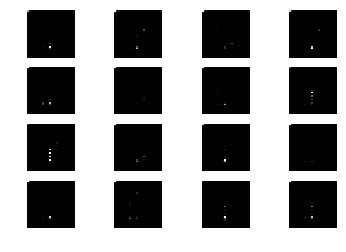

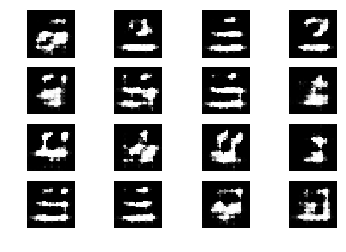

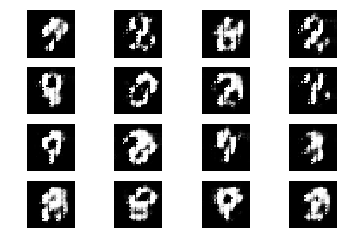

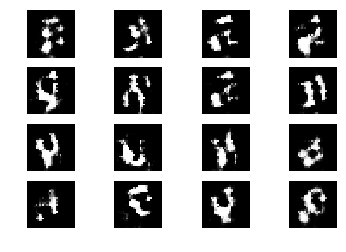

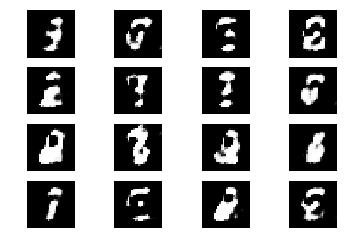

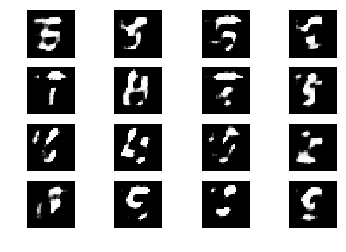

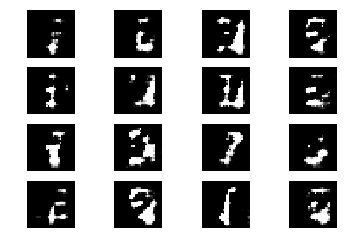

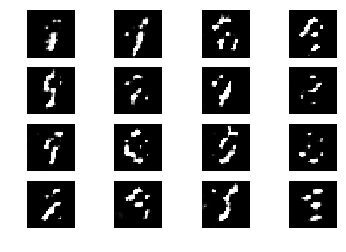

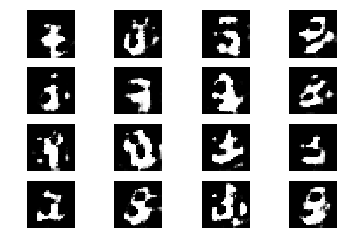

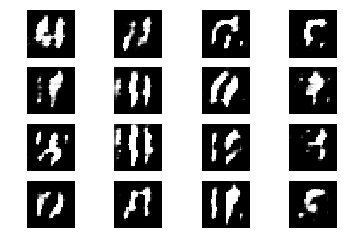

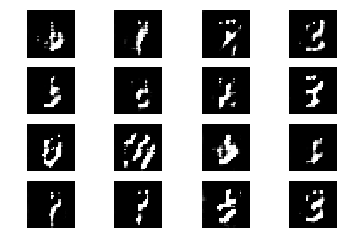

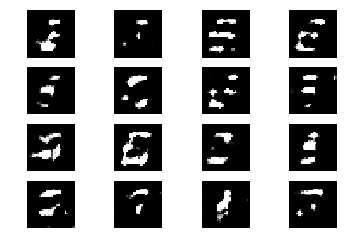

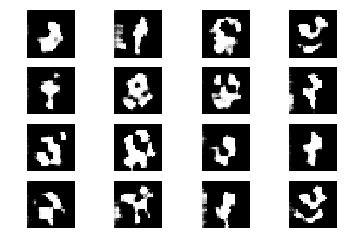

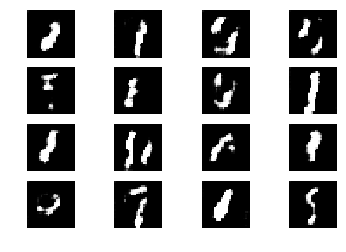

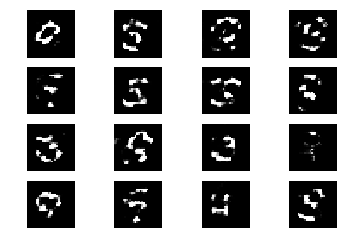

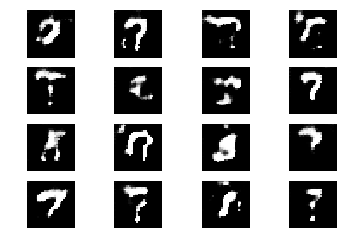

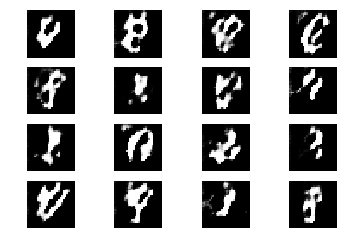

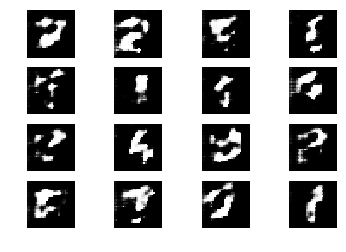

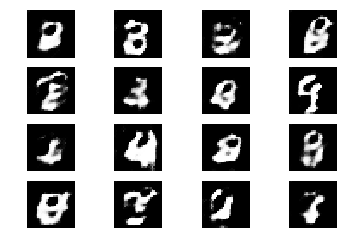

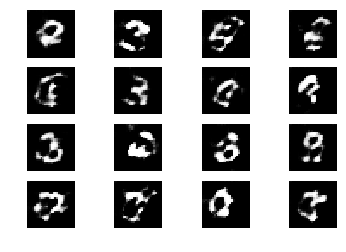

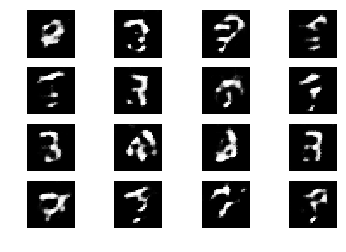

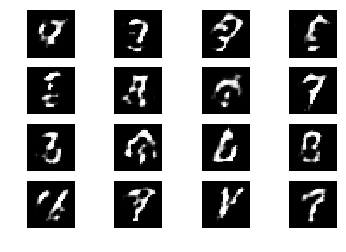

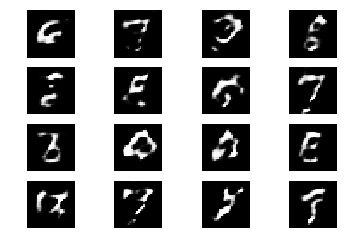

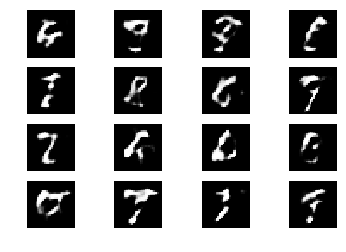

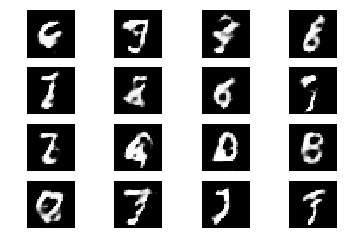

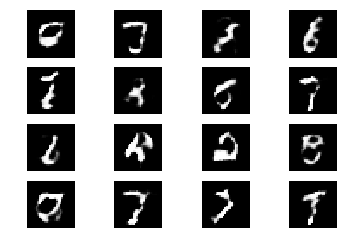

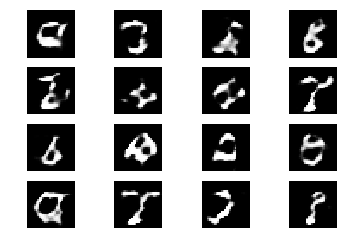

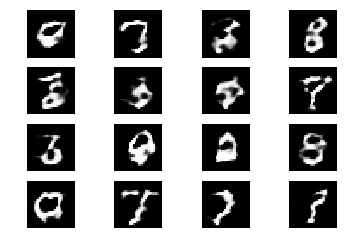

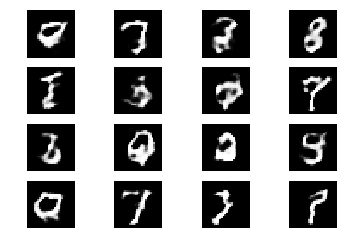

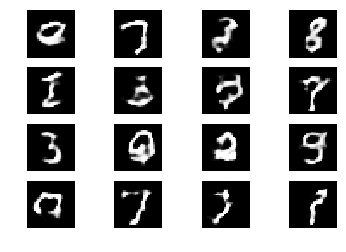

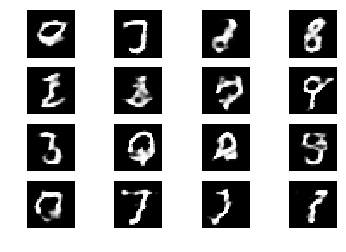

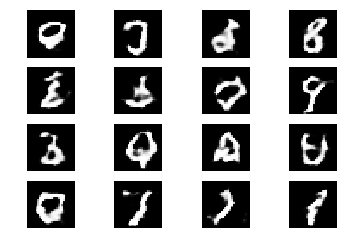

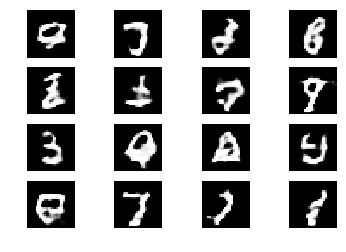

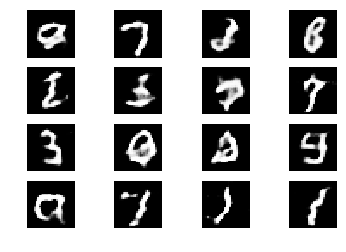

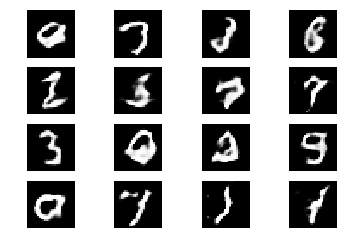

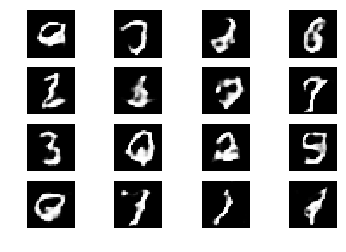

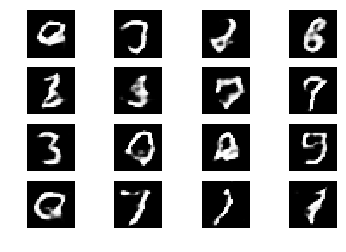

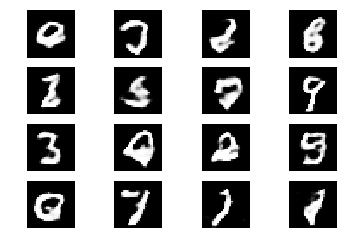

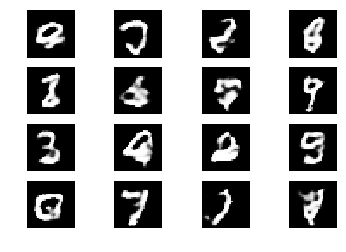

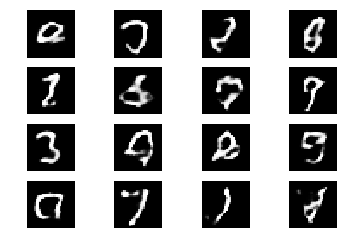

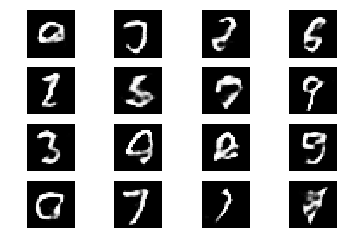

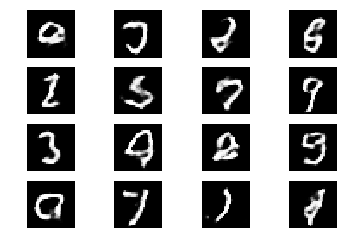

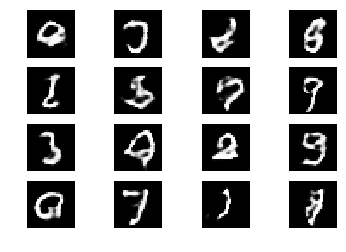

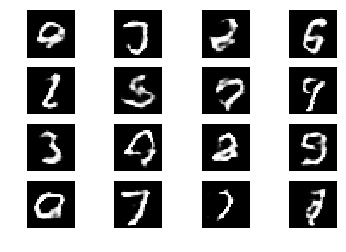

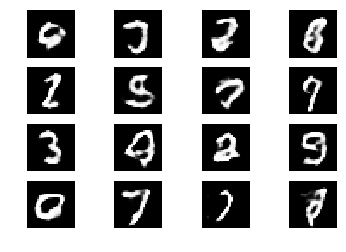

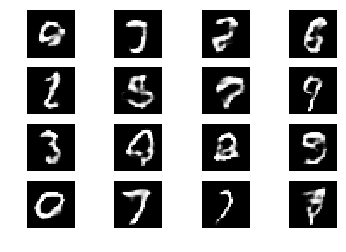

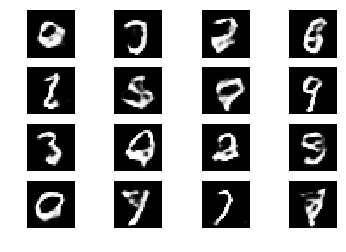

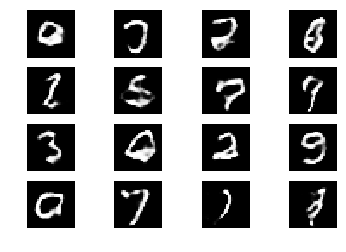

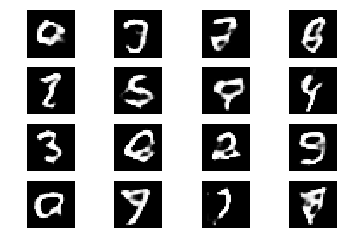

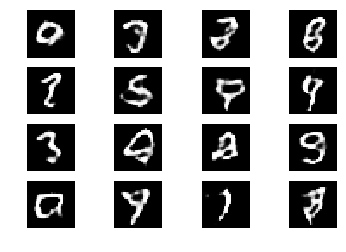

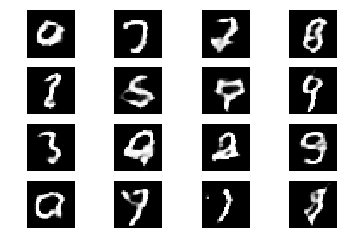

In [15]:
# 模型训练
train(train_dataset, epochs)